# Self-supervised attempt

In [246]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
from skimage.metrics import structural_similarity as ssim_sk
from piqa import SSIM
from dloader import *
from srcnn import *
from unet import *
from resunet import *
from haunet import *
from mrunet import *
from zssrnet import *

DEVICE  = "cuda:0" if torch.cuda.is_available() else "cpu"
PATH_LR = "/mnt/LOCALDATA/STUDENTS/SATELLITE/MODIS/MOD11B1"
PATH_HR = "/mnt/LOCALDATA/STUDENTS/SATELLITE/MODIS/MOD11A1"
QA      = "/home/giacomo.t/src/scanning_paired_dataset.csv"
PARAMS  = "/home/giacomo.t/src/train_params_tiles_2019_2020_2021_2022.csv"
UP_SCALE = 6
KERNEL_SIZE = 5
SEED = 8609

Example data loading from MODIS LST 1km product.

Collected # paired HR data:  25


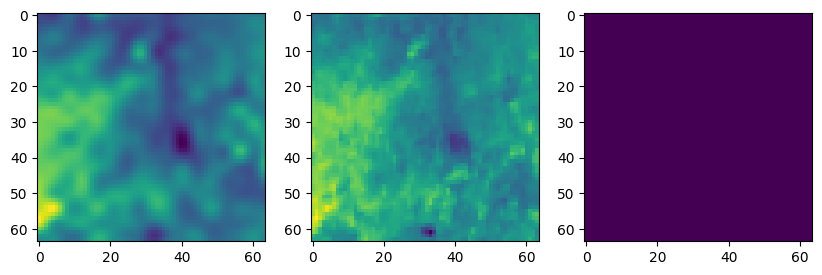

In [3]:

# Load sample image
mds = MODIS_dataset_single(
    hr_filepath=PATH_HR,
    qa=QA,
    zerof_thr=0.01,
    cloud_thr=0.01,
    error_thr=0.01,
    impute_thr=0.01,
    up_scale=4,
    kernel_size=KERNEL_SIZE,
    train_params=PARAMS,
    data_set="train",
    seed=SEED)

imgindex = 2

dl  = torch.utils.data.DataLoader(mds, batch_size=1, shuffle=False, num_workers=4)
dl = iter(dl)
for _ in range(imgindex):
    lr, hr, bm = dl.__next__()
    
_, axs = plt.subplots(1,3,figsize=(10,10))
axs[0].imshow(lr.to("cpu").squeeze())
axs[1].imshow(hr.to("cpu").squeeze())
axs[2].imshow(bm.to("cpu").squeeze())
plt.show()

percentage of zero-filled: 0.0002722222125157714
data range  {min, max}:  288.5199890136719 317.4200134277344
data range  {min, max}:  0.9089533686637878 1.0
data params {mean, std}: 0.9551867246627808 0.010195571929216385


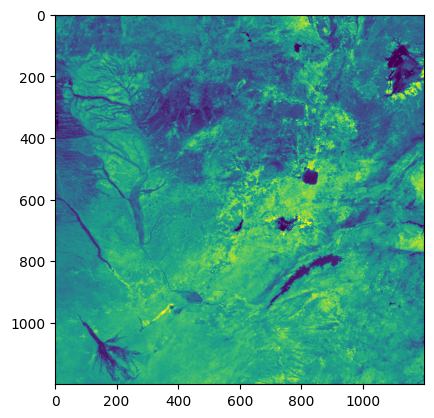

In [37]:
# Reading
filename = mds.qa.iloc[imgindex].hr_files
data = SD(os.path.join(PATH_HR, filename), SDC.READ)
data = data.select("LST_Day_1km")[:,:].astype(np.float64)
data = torch.Tensor(data*0.02)

# Preprocessing

# Imputing zerofilled
print("percentage of zero-filled:", torch.where(data==0, 1, 0).float().mean().item())
data = torch.where(data==0, data[data!=0].mean(), data)

# Rescaling by the highest value
print("data range  {min, max}: ", data.min().item(), data.max().item())
datamin, datamax = data.min().item(), data.max().item()
data = data / datamax

# Collect lower and upper limit for visualisation purposes
print("data range  {min, max}: ", data.min().item(), data.max().item())
datamean, datastd = data.mean().item(), data.std().item()
llim, ulim = datamean-3*datastd , datamean+3*datastd

print("data params {mean, std}:", datamean, datastd)
plt.imshow(data, vmin=llim, vmax=ulim)
plt.show()

## Perform subpatch extraction

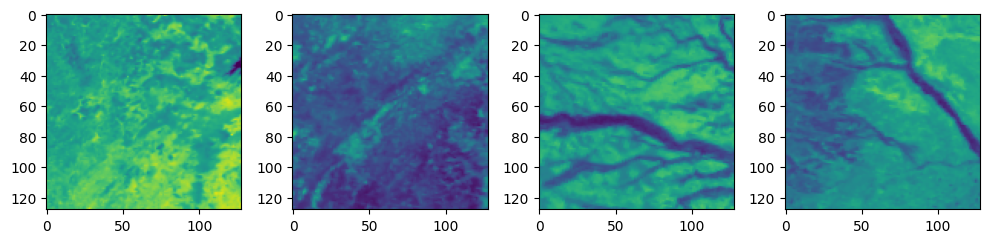

In [3]:
import torchvision.transforms as tt
patch_size = (128, 128)

nimages = 4
subpatch = [tt.Compose([tt.RandomCrop(patch_size)])(data) for _ in range(nimages)]

_, axs = plt.subplots(1, nimages, figsize=(10,8))
for i in range(nimages):
    axs[i].imshow(subpatch[i], vmin=llim, vmax=ulim)
plt.tight_layout()
plt.show()

## Degradation

/home/giacomo.t/.conda/envs/sr_gt_cuda116/lib/python3.9/site-packages/torch/_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


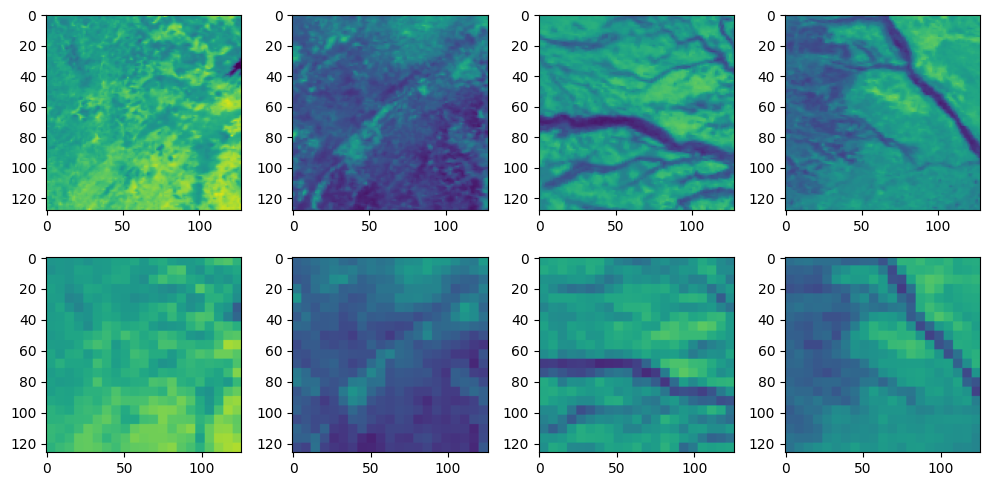

In [4]:
def degrade(x, sf):
    x = x.resize(1,1,x.shape[-2], x.shape[-1])
    x = F.interpolate(x, scale_factor=1/sf, mode="bicubic", antialias=True)
    #x = tt.Compose([tt.GaussianBlur(5)])(x)
    x = F.interpolate(x, scale_factor=sf, mode="nearest-exact", antialias=False)
    return x.squeeze()

scale_factor = 6

child_subpatches = [degrade(subpatch[i], scale_factor) for i in range(len(subpatch))]

_, axs = plt.subplots(2, nimages, figsize=(10,5))
for i in range(nimages):
    axs[0][i].imshow(subpatch[i], vmin=llim, vmax=ulim)
for i in range(nimages):
    axs[1][i].imshow(child_subpatches[i], vmin=llim, vmax=ulim)
plt.tight_layout()
plt.show()

## Perform training

In [26]:
class MEA(torch.nn.Module):
    def __init__(self, imputed_weight:float = 0):
        super(MEA, self).__init__()
        self.imputed_weight = imputed_weight

    def forward(self, x, y):
        mae = torch.abs(torch.subtract(x,y)).float().mean()
        return mae


def degrade(x, sf):
    # if haunet is used: do not rescale back to target dim
    x = F.interpolate(x, scale_factor=1/sf, mode="bicubic", antialias=True)
    #x = tt.Compose([tt.GaussianBlur(3)])(x)
    #x = F.interpolate(x, scale_factor=sf, mode="nearest-exact", antialias=False)
    return x

def get_parents_child(hr, patch_size, scale_factor, batch_size):
    parents = torch.cat([tt.Compose([tt.RandomCrop(patch_size)])(hr).unsqueeze(0).unsqueeze(0) for _ in range(batch_size)], 0)
    child   = degrade(parents, scale_factor)
    return parents, child

def get_loss():
    #return MEA()
    return torch.nn.MSELoss()

def get_optim(lr):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0)
    return optimizer

def get_scheduler(optimizer):
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
        factor=0.1, patience=10, threshold=0.0000001, threshold_mode='abs')
    return scheduler

def build_model():
    #model = MRUNet(res_down=True, n_resblocks=16, bilinear=0).to(DEVICE)
    model = build_haunet(scale_factor=scale_factor, nchannels=1, multi_image=False)
    model = model.to(DEVICE)
    return model

hr = data.to(DEVICE)
patch_size = (64,64)
batch_size = 1
scale_factor = 4

model = build_model()
loss_function = get_loss()
optimizer = get_optim(lr = 0.001)
scheduler = get_scheduler(optimizer)

parents, child = get_parents_child(hr, patch_size, scale_factor, batch_size)

In [29]:
nepochs = 100

model.train()
progression_bar = tqdm(range(nepochs), total=nepochs)
for e in progression_bar:
    
    #parents, child = get_parents_child(hr, patch_size, scale_factor, batch_size)
    
    output = model(child).to(DEVICE)
    
    loss = loss_function(parents, output) # db
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(loss.item())
    
    progression_bar.set_postfix_str(f" Training Loss « {(loss.item())} »")

100%|██████████| 100/100 [00:25<00:00,  3.98it/s,  Training Loss « 1.5430852727149613e-05 »]


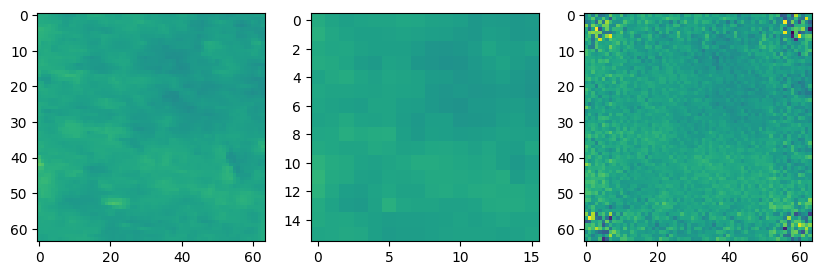

In [30]:
# Example plotting
if batch_size == 1:
    _, axs = plt.subplots(1, 3, figsize=(10,8))
    axs[0].imshow(parents.detach().to("cpu").squeeze(), vmin=llim, vmax=ulim)
    axs[1].imshow(child.detach().to("cpu").squeeze(), vmin=llim, vmax=ulim)
    axs[2].imshow(output.detach().to("cpu").squeeze(), vmin=llim, vmax=ulim)
    
else:
    nimages = 4
    _, axs = plt.subplots(3, nimages, figsize=(10,8))
    for i in range(nimages):
        axs[0][i].imshow(parents[i,:,:,:].detach().to("cpu").squeeze(), vmin=llim, vmax=ulim)
    for i in range(nimages):
        axs[1][i].imshow(child[i,:,:,:].detach().to("cpu").squeeze(), vmin=llim, vmax=ulim)
    for i in range(nimages):
        axs[2][i].imshow(output[i,:,:,:].detach().to("cpu").squeeze(), vmin=llim, vmax=ulim)
    plt.tight_layout()
    plt.show()

In [84]:
parents, child = get_parents_child(hr, patch_size, scale_factor, batch_size)

model.eval()
with torch.no_grad():
    inference = model(child)

In [13]:
#testing haunet
parents, child = get_parents_child(hr, patch_size, scale_factor, batch_size=1)
model(child).shape

torch.Size([1, 1, 128, 128])


---



# Testing ZSSR using RGB image

In [51]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import PIL as PIL
from pyhdf.SD import SD, SDC
from piqa import SSIM
from dloader import *
from srcnn import *
from unet import *
from resunet import *
from haunet import *
from mrunet import *
from zssrnet import *

DEVICE  = "cuda:0" if torch.cuda.is_available() else "cpu"
PATH_LR = "/mnt/LOCALDATA/STUDENTS/SATELLITE/MODIS/MOD11B1"
PATH_HR = "/mnt/LOCALDATA/STUDENTS/SATELLITE/MODIS/MOD11A1"
QA      = "/home/giacomo.t/src/scanning_paired_dataset.csv"
PARAMS  = "/home/giacomo.t/src/train_params_tiles_2019_2020_2021_2022.csv"
UP_SCALE = 6
KERNEL_SIZE = 5
SEED = 8609

class PSNR:
    """Peak Signal to Noise Ratio
    img1 and img2 have range [0, 255]"""
    def __init__(self):
        self.name = "PSNR"
    @staticmethod
    def __call__(img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        return (20 * torch.log10(255.0 / torch.sqrt(mse))).item()

Testing Zero-shot Super Resolution with RGB image from Imagenet-A

torch.Size([3, 200, 200])
Original tensor dimension: torch.Size([1, 3, 200, 200])


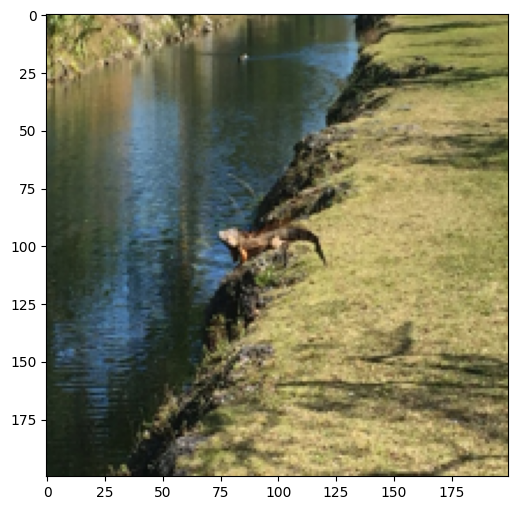

In [52]:
# Testing zsrr with alligator.jpg
imgfilename = "alligator.jpg"
resizedim = (200,200)

# Loading image (to tensor)
img = PIL.Image.open(imgfilename).convert("RGB").resize(resizedim)

# Channel selection
nchannels = 3
hr  = ttf.to_tensor(img) if nchannels == 3 else ttf.to_tensor(img)[0,:,:]
print(hr.shape)

# Normalization and params extractions (for plotting purposes)
hr = hr / hr.max()

hr = hr.reshape(1, nchannels, hr.shape[-2], hr.shape[-1])
print("Original tensor dimension:", hr.shape)

# Plotting
_, axs = plt.subplots(1, 1, figsize=(6,6))
axs.imshow(img)
plt.show()

### Rescaling
Pretext original image degradation via bicubic interpolation according to a given `scale_factor`

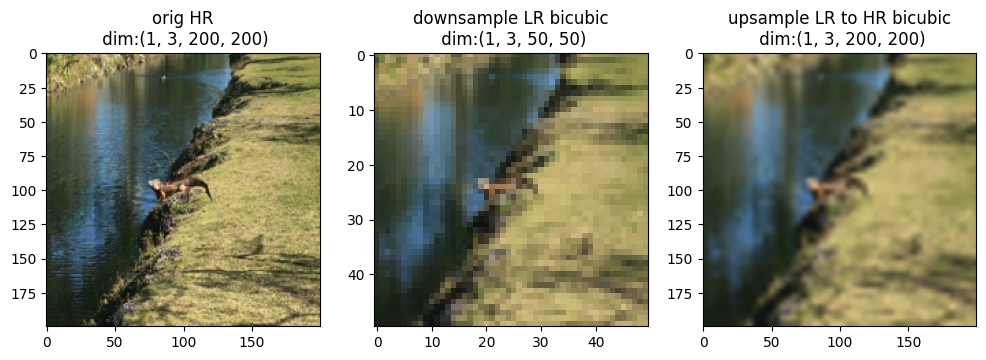

In [ ]:
scale_factor = 4

# Down and Up scaling via bicubic interpolation
child    = F.interpolate(hr, scale_factor=1/scale_factor, mode="bicubic", antialias=True)
child_up = F.interpolate(child, scale_factor=scale_factor, mode="bicubic", antialias=True)

# Plot
titles = ["orig HR", "downsample LR bicubic", "upsample LR to HR bicubic"]
toplot = (hr, child, child_up)
_, axs = plt.subplots(1,len(toplot),figsize=(12,6))
for i,item in enumerate(toplot):
    axs[i].imshow(ttf.to_pil_image(item.squeeze()))
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.show()

### Model initialization

In [130]:
#model = ZSSRNet(input_channels=nchannels, kernel_size=3, channels=64).to(DEVICE)
model = build_unet(nchannels=nchannels).to(DEVICE)
#model = build_resunet(nchannels=nchannels).to(DEVICE)
#model = build_haunet(scale_factor, nchannels=nchannels, multi_image=False).to(DEVICE)
#model = MRUNet(n_channels=nchannels, n_resblocks=1).to(DEVICE)

# Training specs
loss_function = torch.nn.L1Loss()
optimizer     = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)

#scheduler     = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
#                    factor=0.9, patience=5, threshold=0.0001, threshold_mode='abs')

# To DEVICE
hr = hr.to(DEVICE)
child = child.to(DEVICE)
child_up = child_up.to(DEVICE)

def adjust_learning_rate(optimizer, new_lr):
    """Manually adjusting lr for a given optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

### Training Loop

100%|██████████| 600/600 [00:26<00:00, 22.66it/s,  Training Loss « 0.0014573337 »]


 SR-HR:  PSNR (102.372192)  MAE (0.0014573337)
 LR-HR:  PSNR (71.599533)  MAE (0.0463126861)


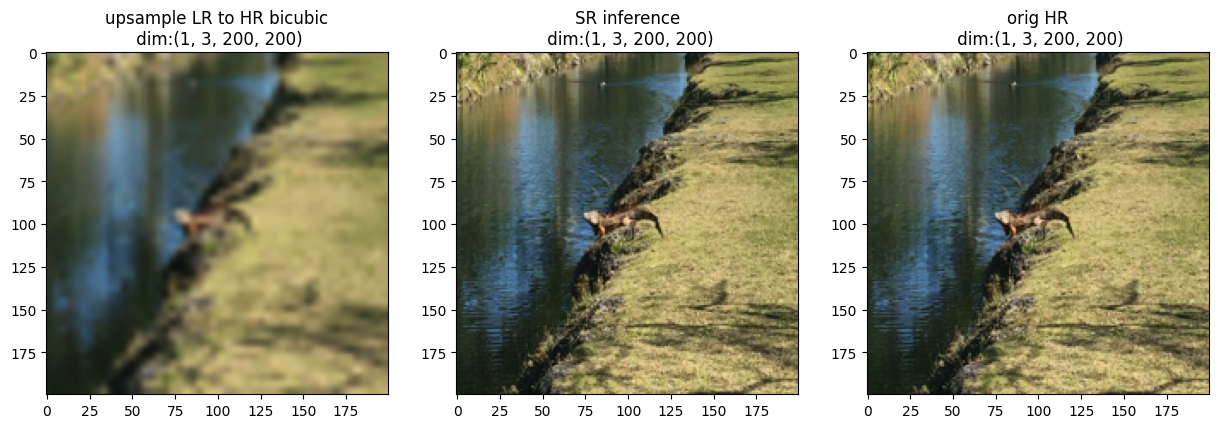

In [142]:
# Training params
nepochs = 600
adjust_learning_rate(optimizer, 10e-4)

# Training loop
model.train()
progression_bar = tqdm(range(nepochs), total=nepochs)
for e in progression_bar:
    output = model(child_up).to(DEVICE)
    loss = loss_function(output, hr)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()
    progression_bar.set_postfix_str(f" Training Loss « {(loss.item()):.10f} »")

# Inference Eval
psnr = PSNR()
print(f" SR-HR:  PSNR ({psnr(output, hr):.6f})  MAE ({loss_function(output, hr):.10f})")
print(f" LR-HR:  PSNR ({psnr(child_up, hr):.6f})  MAE ({loss_function(child_up, hr):.10f})")

# Plot
titles = ["upsample LR to HR bicubic", "SR inference", "orig HR"] 
toplot = (child_up, output, hr)
_, axs = plt.subplots(1,len(toplot),figsize=(15,6))
for i,item in enumerate(toplot):
    axs[i].imshow(ttf.to_pil_image(item.squeeze().detach().to("cpu")),
                                    vmin = vdmean-3*vdstd, vmax = vdmean+3*vdstd)
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.show()

### Now testing zeroshot upscaling
Original HR upsampling according to `scale_factor` and bicubic interpolation.

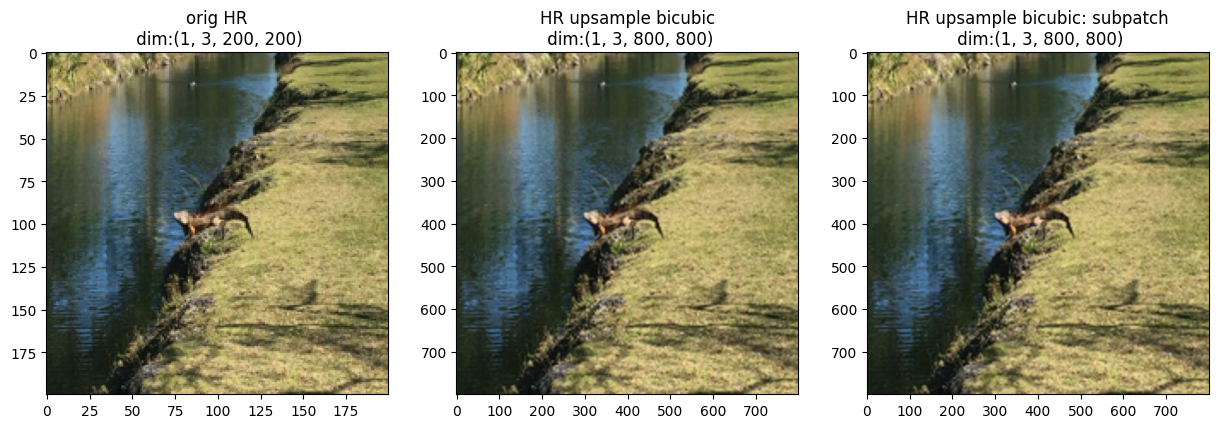

In [138]:
hr_up = F.interpolate(hr, scale_factor=scale_factor, mode="bicubic", antialias=True)
hr_up = hr_up.to(DEVICE)

# Subpatch selection
patch_size = (800,800)
hr_up_subpatch = tt.Compose([tt.RandomCrop(patch_size)])(hr_up)

# Plot
titles = ["orig HR", "HR upsample bicubic", "HR upsample bicubic: subpatch"] 
toplot = (hr, hr_up, hr_up_subpatch)
_, axs = plt.subplots(1,len(toplot),figsize=(15,6))
for i,item in enumerate(toplot):
    axs[i].imshow(ttf.to_pil_image(item.squeeze().detach().to("cpu")),
                  vmin = vdmean-3*vdstd, vmax = vdmean+3*vdstd)
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.show()    

Self-supervised trained model inference estimation.

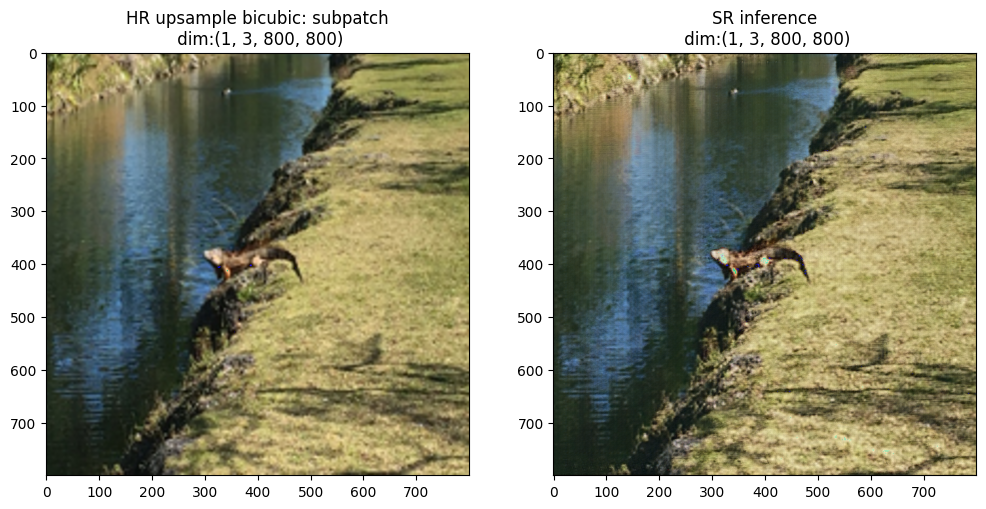

In [140]:
# Evaluating over the new upscaled version
model.eval()
with torch.no_grad():
    inference = model(hr_up_subpatch).to(DEVICE)
    
# Plot
titles = ["HR upsample bicubic: subpatch", "SR inference"] 
toplot = (hr_up_subpatch, inference)
_, axs = plt.subplots(1,len(toplot),figsize=(12,8))
for i,item in enumerate(toplot):
    axs[i].imshow(ttf.to_pil_image(item.squeeze().detach().to("cpu")),
                  vmin = vdmean-3*vdstd, vmax = vdmean+3*vdstd)
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.show()   


---



# Testing ZSSR using MODIS


In [278]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import PIL as PIL
from pyhdf.SD import SD, SDC
from piqa import SSIM
from dloader import *
from srcnn import *
from unet import *
from resunet import *
from haunet import *
from mrunet import *
from zssrnet import *

DEVICE  = "cuda:0" if torch.cuda.is_available() else "cpu"
PATH_LR = "/mnt/LOCALDATA/STUDENTS/SATELLITE/MODIS/MOD11B1"
PATH_HR = "/mnt/LOCALDATA/STUDENTS/SATELLITE/MODIS/MOD11A1"
QA      = "/home/giacomo.t/src/scanning_paired_dataset.csv"
PARAMS  = "/home/giacomo.t/src/train_params_tiles_2019_2020_2021_2022.csv"
UP_SCALE = 6
KERNEL_SIZE = 5
SEED = 8609

class PSNR:
    """Peak Signal to Noise Ratio
    img1 and img2 have range [0, 255]"""
    def __init__(self):
        self.name = "PSNR"
    @staticmethod
    def __call__(img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        return (20 * torch.log10(255.0 / torch.sqrt(mse))).item()

psnr = PSNR()

def ssim(lr, hr):
    """ Custom SSIM implementation
    """
    lr = lr.squeeze().cpu().detach().numpy()
    hr = hr.squeeze().cpu().detach().numpy()
    return ssim_sk(lr, hr, data_range=hr.max()-hr.min(), channel_axis=0)

### Dataset loading and image selection

Collected # paired HR data:  25
percentage of zero-filled: 0.0002722222125157714
data range (K)    {min, max}:  288.5199890136719 317.4200134277344
data range (norm) {min, max}:  0.9089533686637878 1.0
data params   {mean, std}: 0.9551867246627808 0.010195571929216385
data lower and upper value lim: 0.9296977948397398 0.9806756544858217


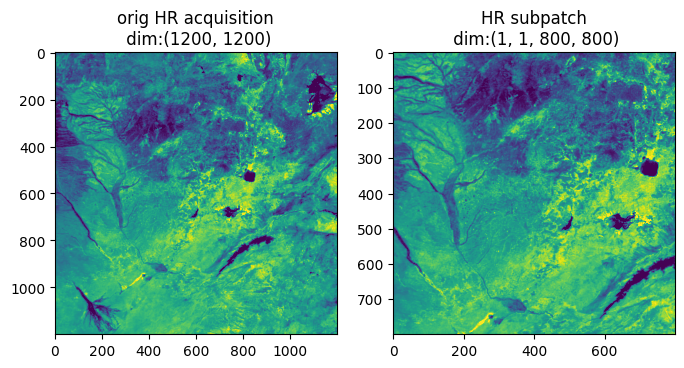

In [332]:
# Load MODIS dataset 
mds = MODIS_dataset_single(hr_filepath=PATH_HR, qa=QA, zerof_thr=0.01,
    cloud_thr=0.01, error_thr=0.01, impute_thr=0.01, up_scale=UP_SCALE, kernel_size=KERNEL_SIZE,
    train_params=PARAMS, data_set="train", seed=SEED)

# HR image reading and rescaling values by sf=0.02 (in K)
imgindex = 2
filename = mds.qa.iloc[imgindex].hr_files
data = SD(os.path.join(PATH_HR, filename), SDC.READ)
data = data.select("LST_Day_1km")[:,:].astype(np.float64)
data = torch.Tensor(data*0.02)

# Imputing zerofilled
print("percentage of zero-filled:", torch.where(data==0, 1, 0).float().mean().item())
data = torch.where(data==0, data[data!=0].mean(), data)

# Rescaling dividing by max value --> [0,1]
print("data range (K)    {min, max}: ", data.min().item(), data.max().item())
dmin, dmax = data.min().item(), data.max().item()
data = data / dmax
print("data range (norm) {min, max}: ", data.min().item(), data.max().item())

# Collect mean and std to clip histogram plotting
datamean, datastd = data.mean().item(), data.std().item()
print("data params   {mean, std}:", datamean, datastd)

# Upper and lower value limits for visualisation purposes
llim, ulim = datamean - 2.5*datastd, datamean + 2.5*datastd
print("data lower and upper value lim:", llim, ulim)

# Subpatch extraction
hlim, wlim = (200,1000), (100,900)
hr = data[hlim[0]:hlim[1], wlim[0]:wlim[1]]
hr = hr.reshape(1, 1, hr.shape[-2], hr.shape[-1])

# Plot
titles = ("orig HR acquisition", "HR subpatch")
toplot = (data, hr)
_, axs = plt.subplots(1, len(toplot), figsize=(8,8))
for i,item in enumerate(toplot):
    axs[i].imshow(item.squeeze().detach().to("cpu"),
                  vmin = llim, vmax = ulim)
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.show()

### Rescaling
Pretext original image degradation via bicubic interpolation according to a given `scale_factor`

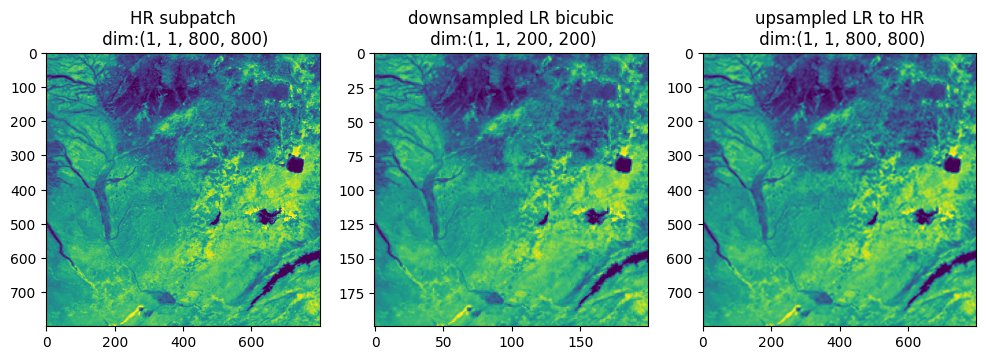

In [333]:
scale_factor = 4

# Interpolate
child = F.interpolate(hr, scale_factor=1/scale_factor, mode="bicubic", antialias=True)
child_up = F.interpolate(child, scale_factor=scale_factor, mode="bicubic", antialias=True)

# Plot
titles = ["HR subpatch", "downsampled LR bicubic", "upsampled LR to HR"]
toplot = (hr, child, child_up)
_, axs = plt.subplots(1, len(toplot), figsize=(12,6))
for i,item in enumerate(toplot):
    axs[i].imshow(item.squeeze().to("cpu"), vmin = llim, vmax = ulim)
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.show()

### Model initialization

In [334]:
nchannels = 1

# Model initialisation
#model = build_unet(nchannels=nchannels).to(DEVICE)
#model = ZSSRNet(input_channels=nchannels, kernel_size=3, channels=128).to(DEVICE)
#model = build_resunet(nchannels=nchannels).to(DEVICE)
#model = build_haunet(scale_factor, nchannels=nchannels, multi_image=False).to(DEVICE)
model = MRUNet(n_channels=nchannels, n_resblocks=1).to(DEVICE)

# Training specs
loss_function = torch.nn.L1Loss()
optimizer     = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
            factor=0.1, patience=15, threshold=10e-8, threshold_mode='abs')
# To DEVICE
hr = hr.to(DEVICE)
child = child.to(DEVICE)
child_up = child_up.to(DEVICE)

def adjust_learning_rate(optimizer, new_lr):
    """Manually adjusting lr for a given optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

### Training Loop

In [335]:
# Training params
nepochs = 500
adjust_learning_rate(optimizer, new_lr=10e-4)

# Training loop
model.train()
cache = np.zeros((nepochs, 3))

gt_loss = loss_function(child_up, hr)
gt_psnr = psnr(child_up, hr)
gt_ssim = ssim(child_up, hr)

progression_bar = tqdm(range(nepochs), total=nepochs)
for e in progression_bar:
    output = model(child_up).to(DEVICE)
    loss = loss_function(output, hr)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(loss.item())
    
    # Performance metrics
    cache[e, 0] = loss.item()
    cache[e, 1] = psnr(output, hr)
    cache[e, 2] = ssim(output, hr) 
    dloss = loss.item() - gt_loss 
    dpsnr = psnr(output, hr) - gt_psnr
    dssim = ssim(output, hr) - gt_ssim
    progression_bar.set_postfix_str(f"Loss «{(loss.item()):.9f}»  Delta Loss «{(dloss):.9f}»  Delta PSNR «{(dpsnr):.9f}»  Delta SSIM «{(dssim):.9f}»")

# Inference Eval
print(f"\n SR-HR:  PSNR ({psnr(output, hr):.6f})  Loss ({loss_function(output, hr):.10f})")
print(f" LR-HR:  PSNR ({psnr(child_up, hr):.6f})  Loss ({loss_function(child_up, hr):.10f})")

# Plot training curves
titles = ["Train Loss", "PSNR", "SSIM"] 
_, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].plot(cache[:,0]); axs[0].axhline(gt_loss.item(), c="red"); axs[0].set_title(f"{titles[0]}, epochs: {nepochs}");  axs[0].grid()
axs[1].plot(cache[:,1]); axs[1].axhline(gt_psnr, c="red"); axs[1].set_title(f"{titles[1]}, epochs: {nepochs}");  axs[1].grid()
axs[2].plot(cache[:,2]); axs[2].axhline(gt_ssim, c="red"); axs[2].set_title(f"{titles[2]}, epochs: {nepochs}"); axs[2].set_ylim((0,1));  axs[2].grid()


# Plot results
titles = ["upsample LR to HR bicubic", "SR inference", "orig HR subpatch"] 
toplot = (child_up, output, hr)
_, axs = plt.subplots(1,len(toplot),figsize=(15,6))
for i,item in enumerate(toplot):
    axs[i].imshow(item.squeeze().detach().to("cpu"),
                vmin = llim, vmax = ulim)
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.show()

 10%|█         | 50/500 [00:34<05:11,  1.44it/s, Loss «0.003463515»  Delta Loss «0.001531601»  Delta PSNR «-12.289321899»  Delta SSIM «-0.056312382»]


KeyboardInterrupt: 

### Now testing zeroshot upscaling
Original HR upsampling according to `scale_factor` and bicubic interpolation.

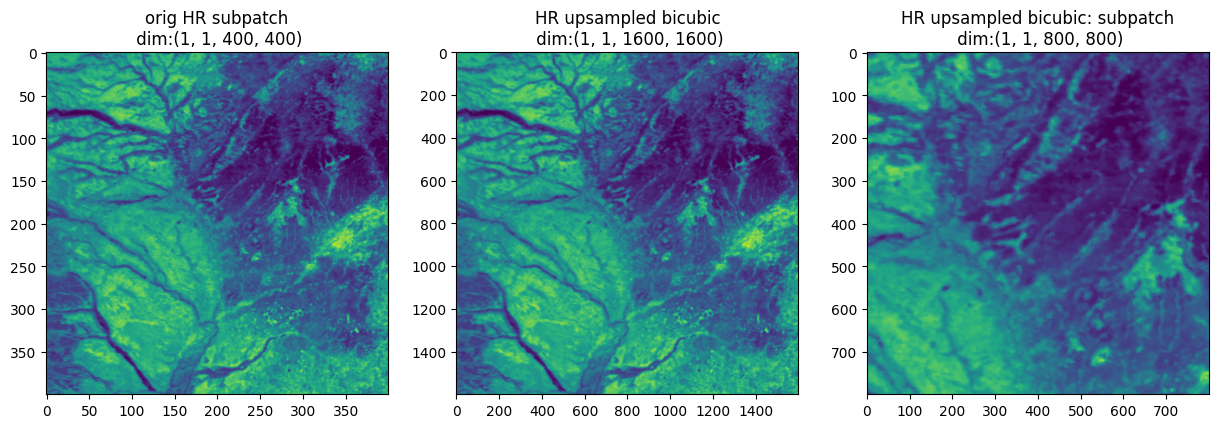

In [314]:
hr_up = F.interpolate(hr, scale_factor=scale_factor, mode="bicubic", antialias=True)
hr_up = hr_up.to(DEVICE)

# Subpatch selection
patch_size = (800,800)
hr_up_subpatch = tt.Compose([tt.RandomCrop(patch_size)])(hr_up)

# Plot
titles = ["orig HR subpatch", "HR upsampled bicubic", "HR upsampled bicubic: subpatch"] 
toplot = (hr, hr_up, hr_up_subpatch)
_, axs = plt.subplots(1,len(toplot),figsize=(15,6))
for i,item in enumerate(toplot):
    axs[i].imshow(item.squeeze().detach().to("cpu"),
                  vmin = llim, vmax = ulim)
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.show()    

Self-supervised trained inference estimation.

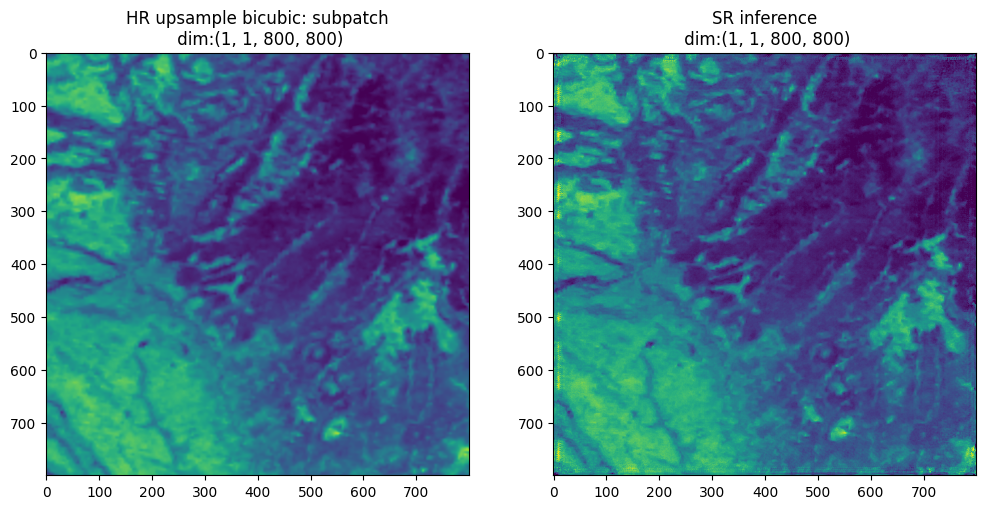

In [317]:
# Evaluating over the new upscaled version
model.eval()
with torch.no_grad():
    inference = model(hr_up_subpatch).to(DEVICE)
    
# Plot
titles = ["HR upsample bicubic: subpatch", "SR inference"] 
toplot = (hr_up_subpatch, inference)
_, axs = plt.subplots(1,len(toplot),figsize=(12,8))
for i,item in enumerate(toplot):
    axs[i].imshow(item.squeeze().detach().to("cpu"),
                  vmin = llim, vmax = ulim)
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.show()   

# Whole Acquisition Training + Inference

In [402]:
# Load MODIS dataset 
mds = MODIS_dataset_single(hr_filepath=PATH_HR, qa=QA, zerof_thr=0.01,
    cloud_thr=0.01, error_thr=0.01, impute_thr=0.01, up_scale=UP_SCALE, kernel_size=KERNEL_SIZE,
    train_params=PARAMS, data_set="train", seed=SEED)

# HR image reading and rescaling values by sf=0.02 (in K)
imgindex = 2
filename = mds.qa.iloc[imgindex].hr_files
data = SD(os.path.join(PATH_HR, filename), SDC.READ)
data = data.select("LST_Day_1km")[:,:].astype(np.float64)
data = torch.Tensor(data*0.02)

# Imputing zerofilled
data = torch.where(data==0, data[data!=0].mean(), data)

# Rescaling dividing by max value --> [0,1]
dmin, dmax = data.min().item(), data.max().item()
data = data / dmax

# Collect mean and std to clip histogram plotting
datamean, datastd = data.mean().item(), data.std().item()

# Upper and lower value limits for visualisation purposes
llim, ulim = datamean - 2.5*datastd, datamean + 2.5*datastd

Collected # paired HR data:  25


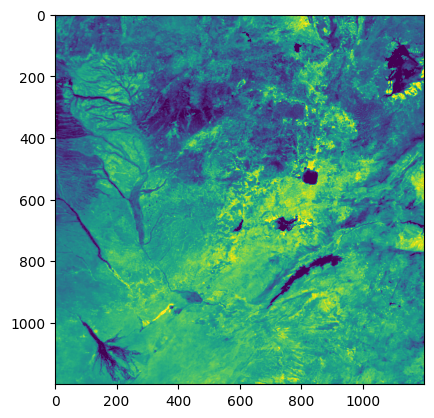

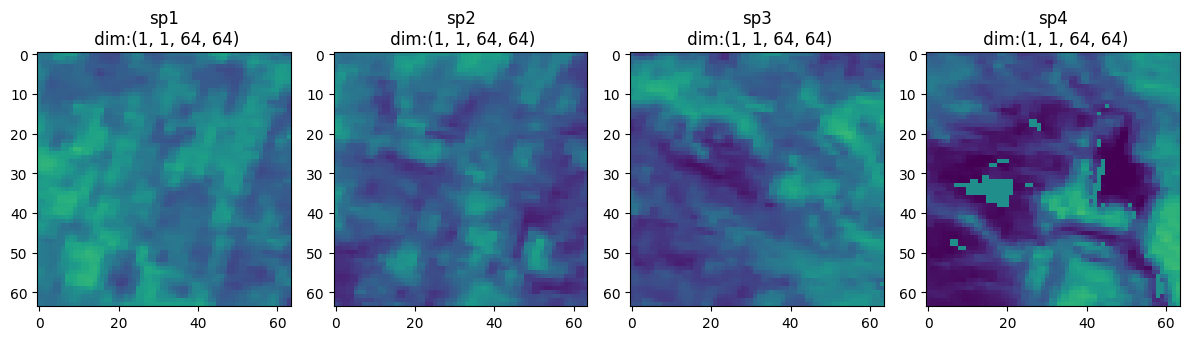

In [408]:
h, w = data.shape
tile_size = 64
subtiles_coords = dict()

# h sub-tiles coords
tiles_h = [(i, i+tile_size) for i in range(0, h, tile_size)] 

# w sub-tiles coords
tiles_w = [(i, i+tile_size) for i in range(0, w, tile_size)] 

# draw sub-tiles from t1-t16
subtiles = []
for _i, coord_h in enumerate(tiles_h):
    for _j, coord_w in enumerate(tiles_w):
        subtiles.append((coord_h[0], coord_h[1], coord_w[0], coord_w[1]))

# store info
subtiles_coords["tiles_h"] = tiles_h # consider to remove this 
subtiles_coords["tiles_w"] = tiles_w
subtiles_coords["tiles_n"] = subtiles


# Drawing 4 countigous sub-patches
batch_size = 4
sps = []
for i in range(batch_size):
    y0,y1,x0,x1 = subtiles_coords["tiles_n"][i]
    sp = data[x0:x1,y0:y1].unsqueeze(0).unsqueeze(0)
    sps.append(sp)    
    
plt.imshow(data, vmin = llim, vmax = ulim)

titles = ["sp1", "sp2", "sp3", "sp4"] 
toplot = sps
_, axs = plt.subplots(1,len(toplot),figsize=(12,8))
for i,item in enumerate(toplot):
    axs[i].imshow(item.squeeze().detach().to("cpu"),
                  vmin = llim, vmax = ulim)
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.tight_layout()
plt.show() 

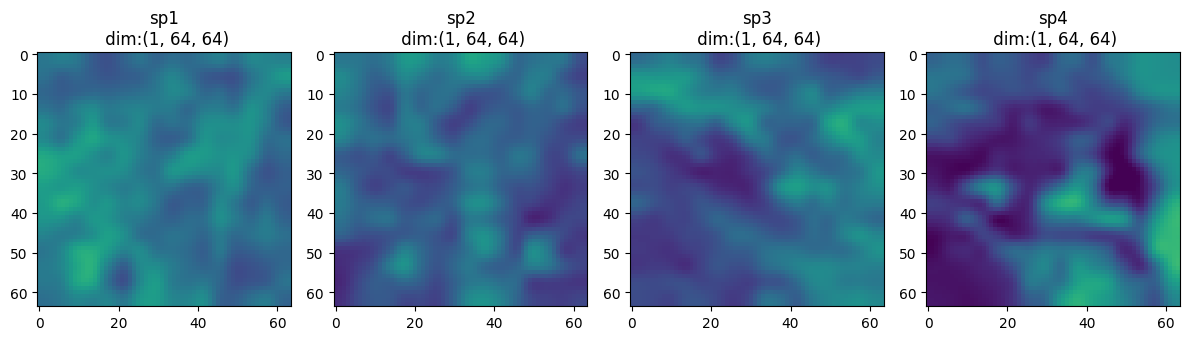

In [409]:
hr = torch.cat(sps, 0)

scale_factor = 4

# Interpolate
child = F.interpolate(hr, scale_factor=1/scale_factor, mode="bicubic", antialias=True)
child_up = F.interpolate(child, scale_factor=scale_factor, mode="bicubic", antialias=True)

# Plot
titles = titles = ["sp1", "sp2", "sp3", "sp4"] 
toplot = child_up
_, axs = plt.subplots(1, toplot.shape[0], figsize=(12,8))
for i,item in enumerate(toplot):
    axs[i].imshow(item.squeeze().to("cpu"), vmin = llim, vmax = ulim)
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.tight_layout()
plt.show()

In [416]:
nchannels = 1

# Model initialisation
model = MRUNet(n_channels=nchannels, n_resblocks=1).to(DEVICE)

# Training specs
loss_function = torch.nn.L1Loss()
optimizer     = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
            factor=0.1, patience=15, threshold=10e-8, threshold_mode='abs')
# To DEVICE
hr = hr.to(DEVICE)
child = child.to(DEVICE)
child_up = child_up.to(DEVICE)

def adjust_learning_rate(optimizer, new_lr):
    """Manually adjusting lr for a given optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

100%|██████████| 2/2 [00:00<00:00, 16.72it/s, Loss «0.001444901»  Delta Loss «-0.000195560»  Delta PSNR «0.789077759»  Delta SSIM «0.064470649»]



 SR-HR:  PSNR (101.498070)  Loss (0.0014449012)
 LR-HR:  PSNR (100.708992)  Loss (0.0016404608)


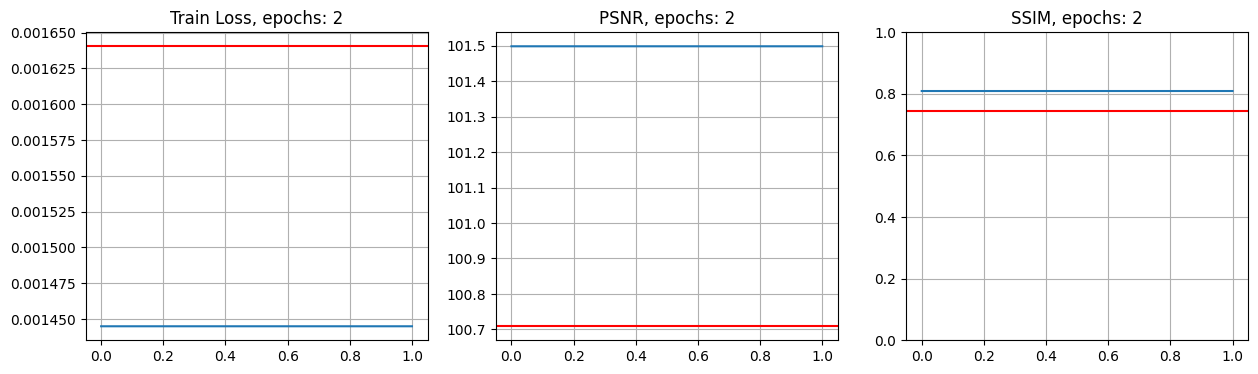

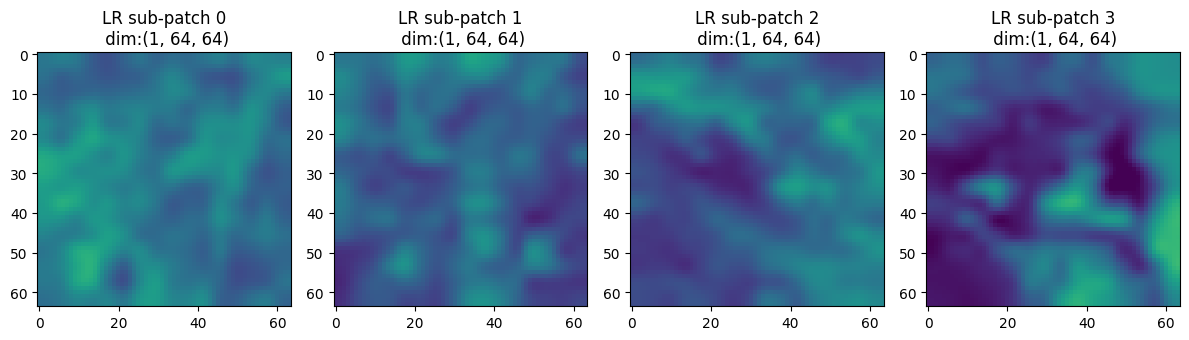

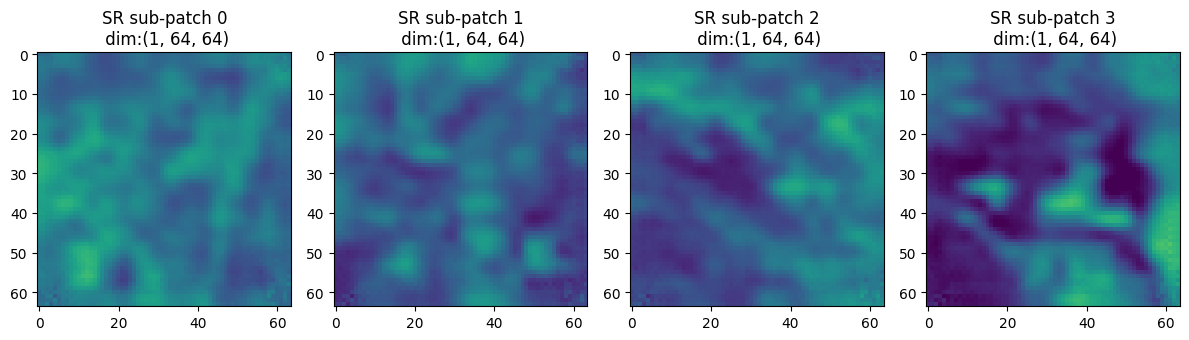

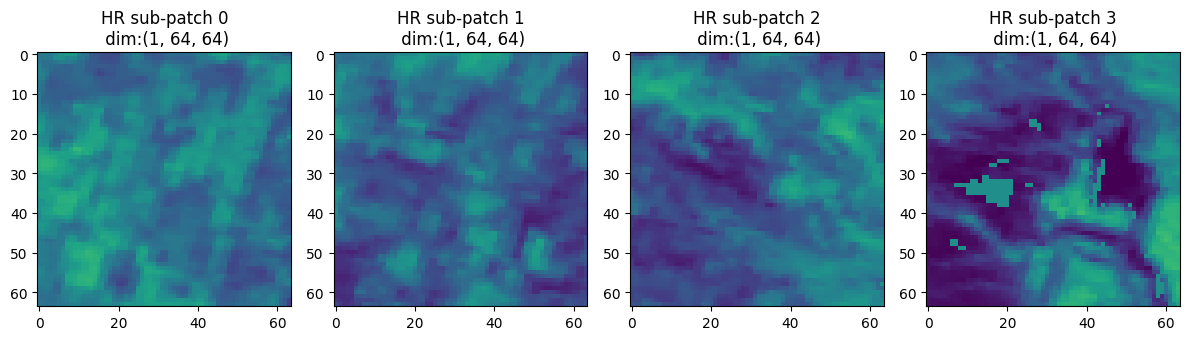

In [424]:
# Training params
nepochs = 2
adjust_learning_rate(optimizer, new_lr=10e-9)

# Training loop
model.train()
cache = np.zeros((nepochs, 3))

gt_loss = loss_function(child_up, hr)
gt_psnr = psnr(child_up, hr)
gt_ssim = ssim(child_up, hr)

progression_bar = tqdm(range(nepochs), total=nepochs)
for e in progression_bar:
    output = model(child_up).to(DEVICE)
    loss = loss_function(output, hr)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #scheduler.step(loss.item())
    
    # Performance metrics
    cache[e, 0] = loss.item()
    cache[e, 1] = psnr(output, hr)
    cache[e, 2] = ssim(output, hr) 
    dloss = loss.item() - gt_loss 
    dpsnr = psnr(output, hr) - gt_psnr
    dssim = ssim(output, hr) - gt_ssim
    progression_bar.set_postfix_str(f"Loss «{(loss.item()):.9f}»  Delta Loss «{(dloss):.9f}»  Delta PSNR «{(dpsnr):.9f}»  Delta SSIM «{(dssim):.9f}»")

# Inference Eval
print(f"\n SR-HR:  PSNR ({psnr(output, hr):.6f})  Loss ({loss_function(output, hr):.10f})")
print(f" LR-HR:  PSNR ({psnr(child_up, hr):.6f})  Loss ({loss_function(child_up, hr):.10f})")

# Plot training curves
titles = ["Train Loss", "PSNR", "SSIM"] 
_, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].plot(cache[:,0]); axs[0].axhline(gt_loss.item(), c="red"); axs[0].set_title(f"{titles[0]}, epochs: {nepochs}");  axs[0].grid()
axs[1].plot(cache[:,1]); axs[1].axhline(gt_psnr, c="red"); axs[1].set_title(f"{titles[1]}, epochs: {nepochs}");  axs[1].grid()
axs[2].plot(cache[:,2]); axs[2].axhline(gt_ssim, c="red"); axs[2].set_title(f"{titles[2]}, epochs: {nepochs}"); axs[2].set_ylim((0,1));  axs[2].grid()


# Plot LR 
titles = [f"LR sub-patch {i}" for i in range(batch_size)] 
toplot = child_up
_, axs = plt.subplots(1, toplot.shape[0], figsize=(12,8))
for i,item in enumerate(toplot):
    axs[i].imshow(item.squeeze().detach().to("cpu"), vmin = llim, vmax = ulim)
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.tight_layout()
plt.show()

# Plot SR
titles = [f"SR sub-patch {i}" for i in range(batch_size)] 
toplot = output
_, axs = plt.subplots(1, toplot.shape[0], figsize=(12,8))
for i,item in enumerate(toplot):
    axs[i].imshow(item.squeeze().detach().to("cpu"), vmin = llim, vmax = ulim)
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.tight_layout()
plt.show()

# Plot HR
titles = [f"HR sub-patch {i}" for i in range(batch_size)] 
toplot = hr
_, axs = plt.subplots(1, toplot.shape[0], figsize=(12,8))
for i,item in enumerate(toplot):
    axs[i].imshow(item.squeeze().detach().to("cpu"), vmin = llim, vmax = ulim)
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.tight_layout()
plt.show()

In [ ]:
# Individual subpatch optim proc